In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier
import lightgbm as lgb
from tqdm import tqdm


In [3]:
df = pd.read_csv("../final/data/trd_timeline_scaled.csv")


In [4]:
# 데이터 준비
X = df.drop('loan_status', axis=1)
y = df['loan_status']

# bool타입 정수형으로
# XGBoost가 bool type를 처리할 때 문제를 발생시키는 경우가 있음
bool_columns = X.select_dtypes(include=['bool']).columns.tolist()
X[bool_columns] = X[bool_columns].astype(int)

# 1️⃣ 먼저 Train(80%) / Test(20%) 로 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 2️⃣ Train 데이터에서 Validation(20%) 분리 (즉, Train 80% → Train 75%, Valid 25%)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2/0.8, random_state=42, stratify=y_train)

# 출력해서 확인
print(f"Train set size: {X_train.shape[0]} rows")
print(f"Validation set size: {X_valid.shape[0]} rows")
print(f"Test set size: {X_test.shape[0]} rows")


Train set size: 669532 rows
Validation set size: 223178 rows
Test set size: 223178 rows


ExtraTreesClassifier Feature Importances:
                 Feature  Importance
20   last_fico_range_low    0.232648
19  last_fico_range_high    0.212272
7              sub_grade    0.021567
4               int_rate    0.020738
6                  grade    0.017021
..                   ...         ...
21        acc_now_delinq    0.000511
43          num_tl_30dpd    0.000368
42      num_tl_120dpd_2m    0.000098
56  home_ownership_OTHER    0.000019
55   home_ownership_NONE    0.000011

[61 rows x 2 columns]
AdaBoost Classifier Feature Importances:
                                Feature  Importance
20                  last_fico_range_low    0.478665
19                 last_fico_range_high    0.230705
3                                  term    0.060787
12                             fico_avg    0.053482
8                            emp_length    0.042329
..                                  ...         ...
56                 home_ownership_OTHER    0.000000
57                   home_ownershi

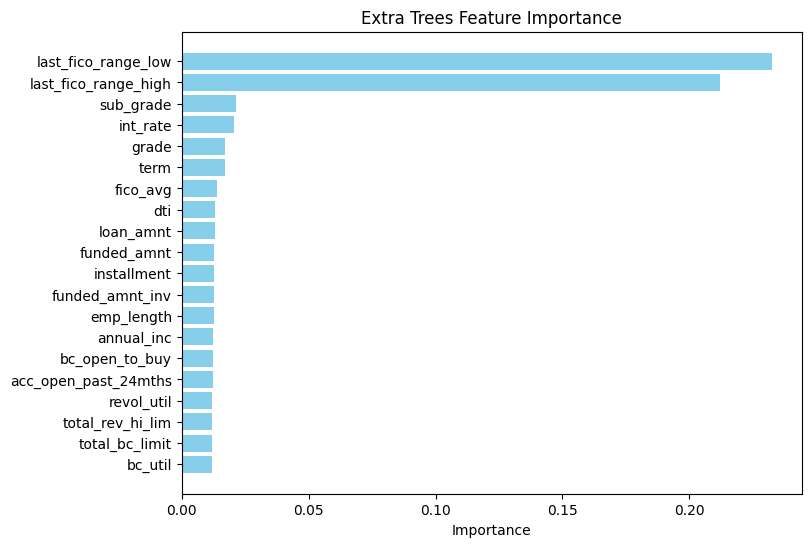

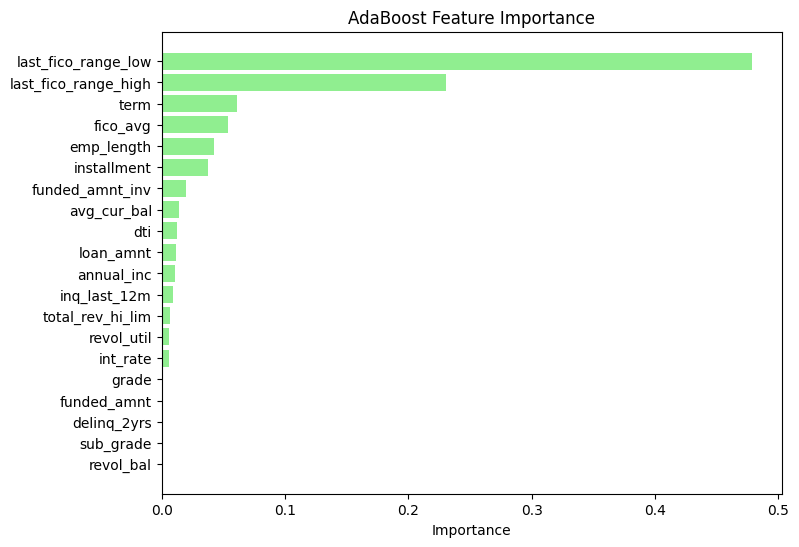

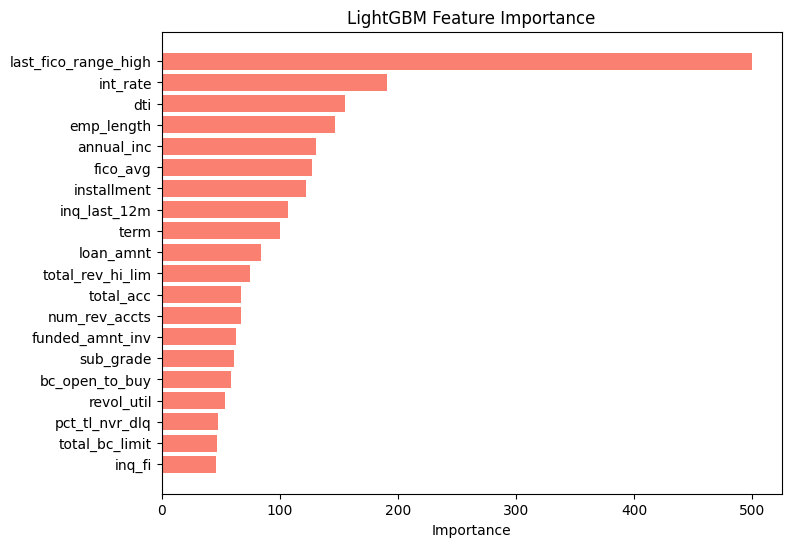

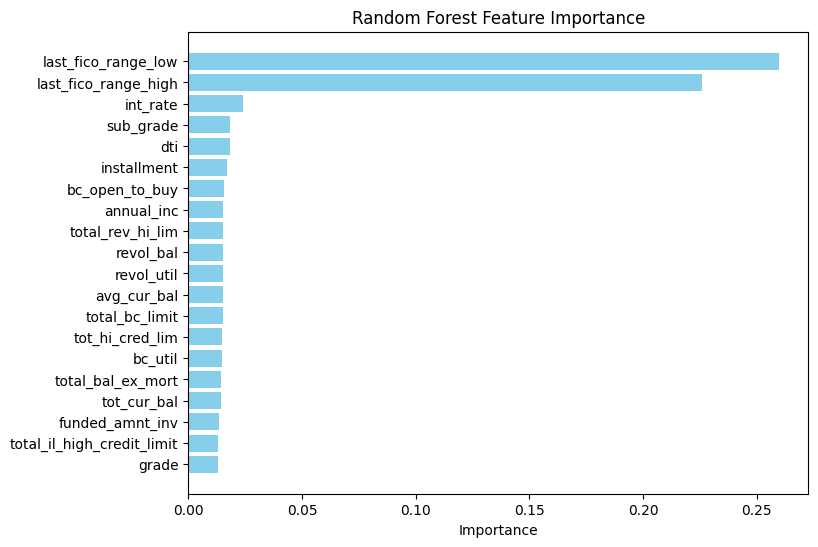

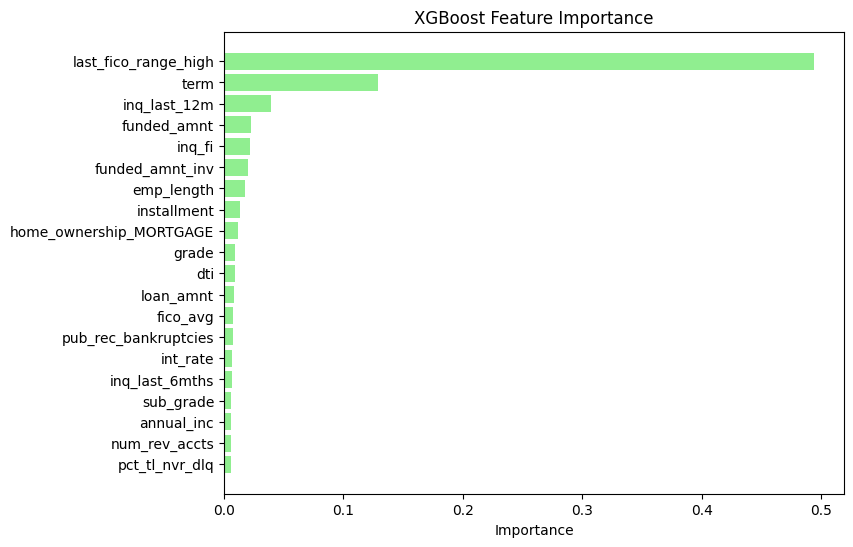

In [5]:
# --- Feature Importance 분석 ---
# 1. Extra Trees Classifier
etc = ExtraTreesClassifier(n_estimators=100, random_state=42)
etc.fit(X_train, y_train)
etc_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': etc.feature_importances_
}).sort_values(by='Importance', ascending=False)
    
print("ExtraTreesClassifier Feature Importances:")
print(etc_importance_df)

# 2. AdaBoost Classifier
ada = AdaBoostClassifier(n_estimators=100, random_state=42)
ada.fit(X_train, y_train)
ada_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': ada.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("AdaBoost Classifier Feature Importances:")
print(ada_importance_df)

# 3. LightGBM Classifier
lgb_model = lgb.LGBMClassifier(random_state=42, force_col_wise=True)
lgb_model.fit(X_train, y_train)
lgb_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': lgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("LightGBM Classifier Feature Importances:")
print(lgb_importance_df)

# 4. RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
rf_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Random Forest Feature Importances:")
print(rf_importance_df)

# 5. XGBoost Classifier
xgb = XGBClassifier(random_state=42, eval_metric='mlogloss')
xgb.fit(X_train, y_train)
xgb_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("XGBoost Feature Importances:")
print(xgb_importance_df)

# --- Feature Importance 시각화 ---
def plot_feature_importance(df, title, color='skyblue'):
    # 상위 20개 Feature만 선택
    df_top20 = df.head(20)
    plt.figure(figsize=(8, 6))
    plt.barh(df_top20['Feature'], df_top20['Importance'], color=color)
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.xlabel("Importance")
    plt.show()

plot_feature_importance(etc_importance_df, "Extra Trees Feature Importance", 'skyblue')
plot_feature_importance(ada_importance_df, "AdaBoost Feature Importance", 'lightgreen')
plot_feature_importance(lgb_importance_df, "LightGBM Feature Importance", 'salmon')
plot_feature_importance(rf_importance_df, "Random Forest Feature Importance")
plot_feature_importance(xgb_importance_df, "XGBoost Feature Importance", 'lightgreen')


In [6]:
# Model running with selected feature
model_info = {
    'ExtraTrees': {
        'model': ExtraTreesClassifier(n_estimators=100, random_state=42),
        'importance_df': etc_importance_df
    },
    'AdaBoost': {
        'model': AdaBoostClassifier(n_estimators=100, random_state=42),
        'importance_df': ada_importance_df
    },
    'LightGBM': {
        'model': lgb.LGBMClassifier(random_state=42, force_col_wise=True, verbose=-1),
        'importance_df': lgb_importance_df
    },
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'importance_df': rf_importance_df
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42, objective='binary:logistic', eval_metric='logloss'),
        'importance_df': xgb_importance_df
    }
}

results = {}

for model_name, info in model_info.items():
    clf = info['model']
    importance_df = info['importance_df']
    
    # 상위 20개 Feature 선택 (이미 내림차순 정렬되어 있다고 가정)
    top_features = importance_df['Feature'].head(30).tolist()
    
    # 선택된 Feature들만 사용해서 Train, Validation, Test 데이터셋 생성
    X_train_top = X_train[top_features]
    X_valid_top = X_valid[top_features]
    X_test_top  = X_test[top_features]
    
    # 해당 모델로 학습
    clf.fit(X_train_top, y_train)
    
    # 예측 및 정확도 평가
    y_valid_pred = clf.predict(X_valid_top)
    y_test_pred  = clf.predict(X_test_top)
    
    valid_acc = accuracy_score(y_valid, y_valid_pred)
    test_acc  = accuracy_score(y_test, y_test_pred)
    
    # 결과 저장
    results[model_name] = {
        'top_features': top_features,
        'valid_accuracy': valid_acc,
        'test_accuracy': test_acc
    }

# 각 모델별 결과 출력
for model_name, res in results.items():
    print(f"==== {model_name} 기반 상위 20 Feature 사용 ====")
    print("Top 20 Features:", res['top_features'])
    print(f"Validation Accuracy: {res['valid_accuracy']:.4f}")
    print(f"Test Accuracy: {res['test_accuracy']:.4f}")
    print("-"*50)


==== ExtraTrees 기반 상위 20 Feature 사용 ====
Top 20 Features: ['last_fico_range_low', 'last_fico_range_high', 'sub_grade', 'int_rate', 'grade', 'term', 'fico_avg', 'dti', 'loan_amnt', 'funded_amnt', 'installment', 'funded_amnt_inv', 'emp_length', 'annual_inc', 'bc_open_to_buy', 'acc_open_past_24mths', 'revol_util', 'total_rev_hi_lim', 'total_bc_limit', 'bc_util', 'num_rev_accts', 'num_tl_op_past_12m', 'num_bc_tl', 'num_il_tl', 'revol_bal', 'total_acc', 'avg_cur_bal', 'tot_hi_cred_lim', 'tot_cur_bal', 'total_bal_ex_mort']
Validation Accuracy: 0.8982
Test Accuracy: 0.8981
--------------------------------------------------
==== AdaBoost 기반 상위 20 Feature 사용 ====
Top 20 Features: ['last_fico_range_low', 'last_fico_range_high', 'term', 'fico_avg', 'emp_length', 'installment', 'funded_amnt_inv', 'avg_cur_bal', 'dti', 'loan_amnt', 'annual_inc', 'inq_last_12m', 'total_rev_hi_lim', 'revol_util', 'int_rate', 'grade', 'funded_amnt', 'delinq_2yrs', 'sub_grade', 'revol_bal', 'inq_last_6mths', 'total_acc

==== ExtraTrees 학습 곡선 시각화 ====


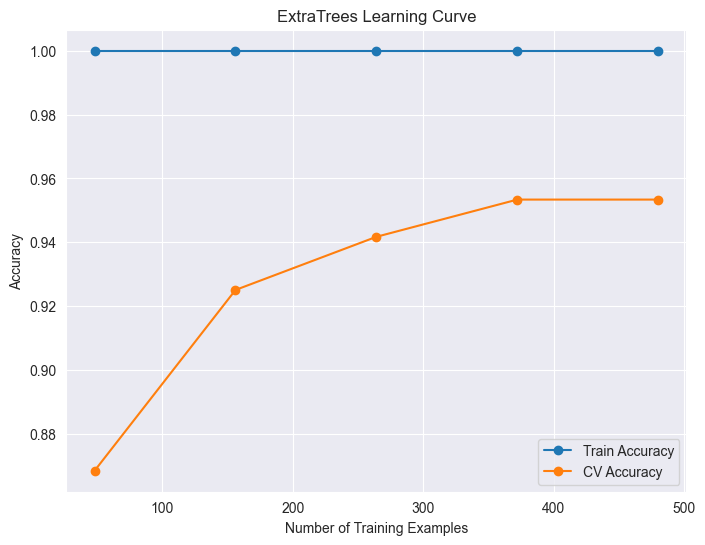

==== AdaBoost 학습 곡선 시각화 ====


C:\Users\user\Desktop\visualize-and-web\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
C:\Users\user\Desktop\visualize-and-web\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
C:\Users\user\Desktop\visualize-and-web\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
C:\Users\user\Desktop\visualize-and-web\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


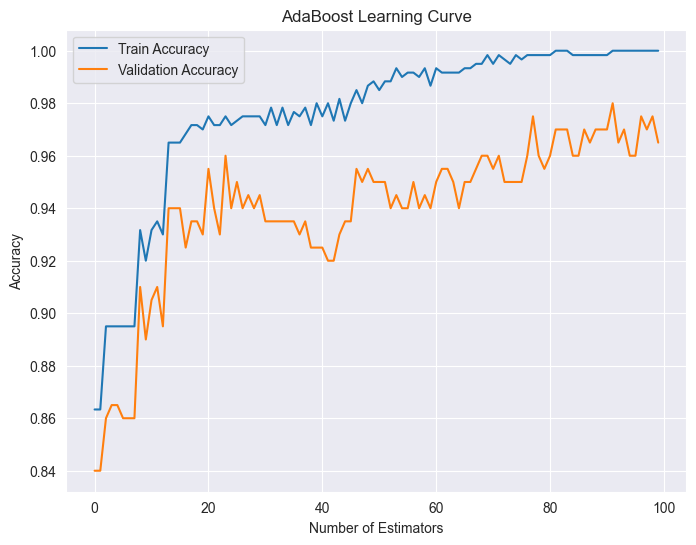

==== LightGBM 학습 곡선 시각화 ====


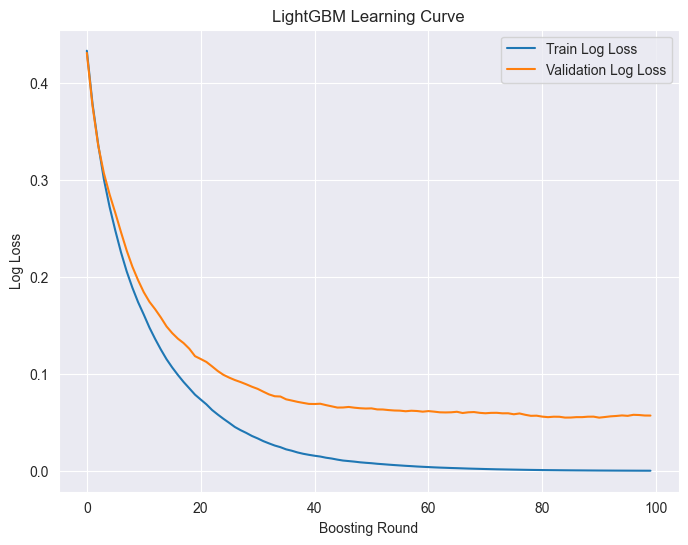

==== RandomForest 학습 곡선 시각화 ====


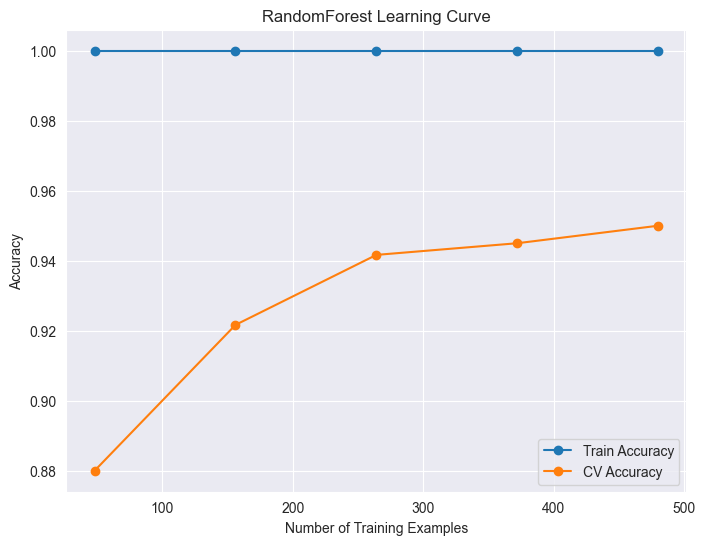

==== XGBoost 학습 곡선 시각화 ====


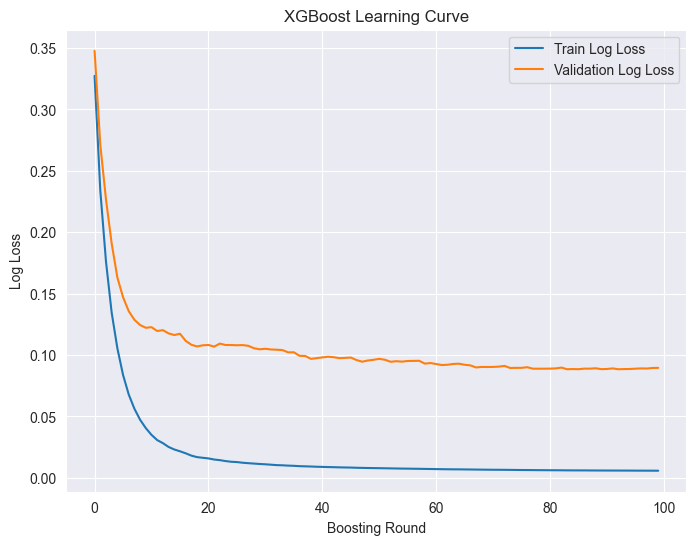

==== SVM 학습 곡선 시각화 ====


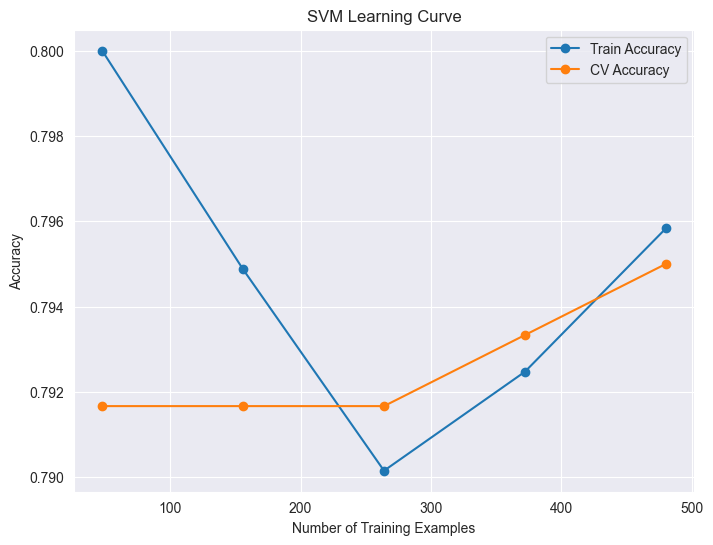

In [60]:
# 학습곡선 시각화
model_info = {
    'ExtraTrees': {
        'model': ExtraTreesClassifier(n_estimators=100, random_state=42),
        'importance_df': etc_importance_df
    },
    'AdaBoost': {
        'model': AdaBoostClassifier(n_estimators=100, random_state=42),
        'importance_df': ada_importance_df
    },
    'LightGBM': {
        'model': lgb.LGBMClassifier(random_state=42, force_col_wise=True, verbose=-1),
        'importance_df': lgb_importance_df
    },
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'importance_df': rf_importance_df
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42, objective='binary:logistic', eval_metric='logloss'),
        'importance_df': xgb_importance_df
    },
}

# 각 모델별 학습 곡선을 시각화
for model_name, info in model_info.items():
    clf = info['model']
    importance_df = info['importance_df']
    
    # 상위 20개 Feature 선택 (이미 내림차순 정렬되어 있다고 가정)
    top_features = importance_df['Feature'].head(30).tolist()
    X_train_top = X_train[top_features]
    X_valid_top = X_valid[top_features]
    
    print(f"==== {model_name} 학습 곡선 시각화 ====")
    
    if model_name == 'AdaBoost':
        # AdaBoost는 staged_score를 제공함 (각 boosting round마다의 정확도를 기록)
        clf.fit(X_train_top, y_train)
        train_scores = list(clf.staged_score(X_train_top, y_train))
        valid_scores = list(clf.staged_score(X_valid_top, y_valid))
        plt.figure(figsize=(8,6))
        plt.plot(train_scores, label='Train Accuracy')
        plt.plot(valid_scores, label='Validation Accuracy')
        plt.xlabel('Number of Estimators')
        plt.ylabel('Accuracy')
        plt.title(f'{model_name} Learning Curve')
        plt.legend()
        plt.show()
    
    elif model_name == 'XGBoost':
        # XGBoost: use eval_set and evals_result to get learning curves (예: 로그 손실)
        eval_set = [(X_train_top, y_train), (X_valid_top, y_valid)]
        clf.fit(X_train_top, y_train, eval_set=eval_set, verbose=False)
        evals_result = clf.evals_result()
        epochs = len(evals_result['validation_0']['logloss'])
        x_axis = range(epochs)
        plt.figure(figsize=(8,6))
        plt.plot(x_axis, evals_result['validation_0']['logloss'], label='Train Log Loss')
        plt.plot(x_axis, evals_result['validation_1']['logloss'], label='Validation Log Loss')
        plt.xlabel('Boosting Round')
        plt.ylabel('Log Loss')
        plt.title(f'{model_name} Learning Curve')
        plt.legend()
        plt.show()
    
    elif model_name == 'LightGBM':
        # LightGBM: use eval_set and evals_result_ (예: binary_logloss 사용, binary classification 가정)
        eval_set = [(X_train_top, y_train), (X_valid_top, y_valid)]
        clf.fit(X_train_top, y_train, eval_set=eval_set)
        evals_result = clf.evals_result_
        train_metric = evals_result['training']['binary_logloss']
        valid_metric = evals_result['valid_1']['binary_logloss']
        epochs = len(train_metric)
        x_axis = range(epochs)
        plt.figure(figsize=(8,6))
        plt.plot(x_axis, train_metric, label='Train Log Loss')
        plt.plot(x_axis, valid_metric, label='Validation Log Loss')
        plt.xlabel('Boosting Round')
        plt.ylabel('Log Loss')
        plt.title(f'{model_name} Learning Curve')
        plt.legend()
        plt.show()
    
    elif model_name in ['ExtraTrees', 'RandomForest']:
        # ExtraTrees와 RandomForest는 staged_score가 없으므로, learning_curve 함수를 사용
        train_sizes, train_scores, cv_scores = learning_curve(
            estimator=clf, 
            X=X_train_top, 
            y=y_train, 
            cv=5, 
            scoring='accuracy', 
            n_jobs=-1,
            train_sizes=np.linspace(0.1, 1.0, 5)
        )
        train_scores_mean = np.mean(train_scores, axis=1)
        cv_scores_mean = np.mean(cv_scores, axis=1)
        plt.figure(figsize=(8,6))
        plt.plot(train_sizes, train_scores_mean, 'o-', label='Train Accuracy')
        plt.plot(train_sizes, cv_scores_mean, 'o-', label='CV Accuracy')
        plt.xlabel('Number of Training Examples')
        plt.ylabel('Accuracy')
        plt.title(f'{model_name} Learning Curve')
        plt.legend()
        plt.show()
    
    else:
        print(f"{model_name}의 학습 곡선 시각화 방법이 정의되어 있지 않습니다.")
